# Exploratory Data Analysis
---  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# from sklearn
import datetime
import statsmodels.api as sm

In [2]:
import matplotlib.style as style 

style.use('seaborn-darkgrid')
sns.set_context('notebook')
sns.set_palette('husl')

In [3]:
train = pd.read_csv('wrangled_data/training_dataframe.csv')
test = pd.read_csv('wrangled_data/testing_dataframe.csv')

In [4]:
train.shape

(1609124, 12)

In [5]:
train.head(3)

,date_block_num,shop_id,item_id,month,year,item_category_id,item_cnt_month,item_cnt_month_mean,item_cnt_prev_month,item_name,item_category_name,shop_name
0,0,0,32,1,2013,40,6.0,8.0,0.0,32,40,0
1,0,0,33,1,2013,37,3.0,3.0,0.0,33,37,0
2,0,0,35,1,2013,40,1.0,7.5,0.0,35,40,0


In [6]:
test.shape

(214200, 12)

In [7]:
test.head(3)

,ID,shop_id,item_id,month,year,date_block_num,item_cnt_month_mean,item_cnt_prev_month,item_name,item_category_id,item_category_name,shop_name
0,0,5,5037,11,2015,34,1.444444,0.0,5037,19,19,5
1,1,5,5320,11,2015,34,0.000000,0.0,5320,55,55,5
2,2,5,5233,11,2015,34,2.000000,1.0,5233,19,19,5


### Time Series Analysis

In [8]:
train['date'] = pd.to_datetime(train[['year', 'month']].assign(DAY=1)).apply(lambda x: x.strftime('%Y-%m'))
# train.drop(columns=['year', 'month'], inplace=True)

In [9]:
train.set_index(['date', 'shop_id', 'item_id'])

date_block_num  month  year  item_category_id  \
date    shop_id item_id                                                  
2013-01 0       32                    0      1  2013                40   
                33                    0      1  2013                37   
                35                    0      1  2013                40   
                43                    0      1  2013                40   
                51                    0      1  2013                57   
...                                 ...    ...   ...               ...   
2015-10 59      22087                33     10  2015                83   
                22088                33     10  2015                83   
                22091                33     10  2015                83   
                22100                33     10  2015                42   
                22102                33     10  2015                42   

                         item_cnt_month  item_cnt_month_mean  \
date    shop_id item_id                                        
2013-01 0       32                  6.0             8.000000   
                33                  3.0             3.000000   
                35                  1.0             7.500000   
                43                  1.0             1.000000   
                51                  2.0             2.500000   
...                                 ...                  ...   
2015-10 59      22087               6.0             6.424242   
                22088               2.0             6.187500   
                22091               1.0             2.294118   
                22100               1.0             1.000000   
                22102               1.0             1.333333   

                         item_cnt_prev_month  item_name  item_category_name  \
date    shop_id item_id                                                       
2013-01 0       32                       0.0         32                  40   
                33                       0.0         33                  37   
                35                       0.0         35                  40   
                43                       0.0         43                  40   
                51                       0.0         51                  57   
...                                      ...        ...                 ...   
2015-10 59      22087                    6.0      22087                  83   
                22088                    2.0      22088                  83   
                22091                    1.0      22091                  83   
                22100                    1.0      22100                  42   
                22102                    1.0      22102                  42   

                         shop_name  
date    shop_id item_id             
2013-01 0       32               0  
                33               0  
                35               0  
                43               0  
                51               0  
...                            ...  
2015-10 59      22087           59  
                22088           59  
                22091           59  
                22100           59  
                22102           59  

[1609124 rows x 10 columns]

In [10]:
train.index = train['date']

In [11]:
train[(train['shop_id'] == 2)].groupby('item_id')['item_cnt_month'].count().sort_values(ascending=False).head()

item_id
4244    33
2808    32
5821    31
3076    30
2308    29
Name: item_cnt_month, dtype: int64

<AxesSubplot:xlabel='date', ylabel='item_cnt_month'>

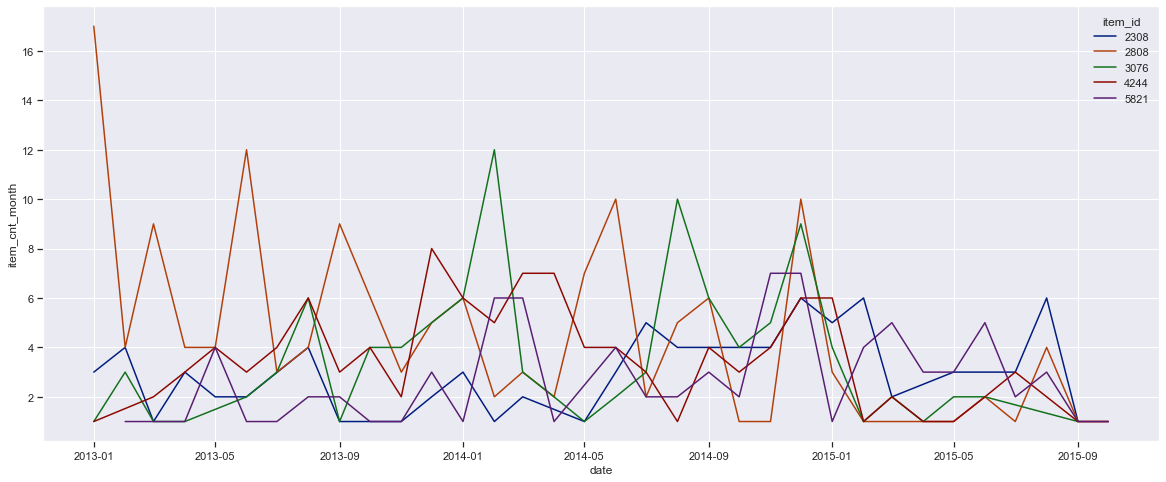

In [12]:
plt.figure(figsize=(20,8))

shop = train[(train['shop_id'] == 2)]
shop = shop[shop['item_id'].isin([4244, 2808, 5821, 3076, 2308])] 
shop = shop.set_index(pd.DatetimeIndex(shop['date']))
shop.drop(columns=['date'], inplace=True)
sns.lineplot(data=shop, x=shop.index, y='item_cnt_month', hue='item_id', palette='dark')

In [13]:
returns = shop[shop['item_id']==5821].pct_change()
autocorrelation = returns['item_cnt_month'].autocorr()
print("The autocorrelation of items sold each month is %4.2f" %(autocorrelation))

The autocorrelation of items sold each month is -0.38


In [14]:
returns = shop[shop['item_id']==5821].diff()
autocorrelation = returns['item_cnt_month'].autocorr()
print("The autocorrelation of items sold each month is %4.2f" %(autocorrelation))

The autocorrelation of items sold each month is -0.42


In [15]:
resample = shop[shop['item_id']==5821].resample('Y')['item_cnt_month'].mean().reset_index().rename(columns={'item_cnt_month':'year_mean'})
resample['year'] = resample['date'].dt.year
resample.drop(columns=['date'], inplace=True)

ret = pd.merge(shop[shop['item_id']==5821].reset_index(), resample, how='left', on='year')
ret.index = ret['date']
ret.drop(columns=['date'], inplace=True)

<AxesSubplot:xlabel='date', ylabel='item_cnt_month'>

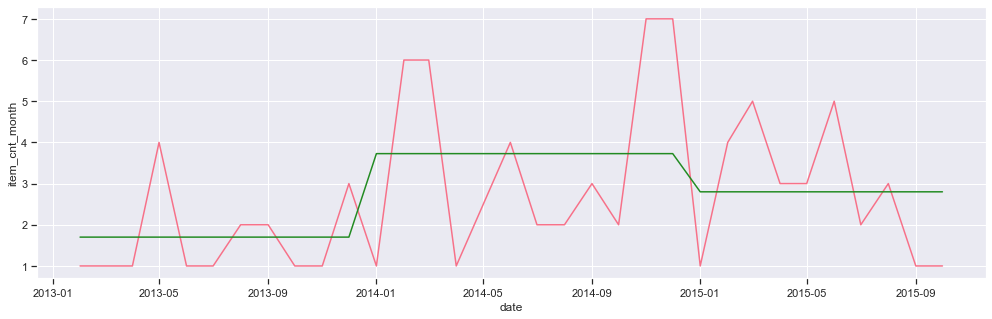

In [16]:
plt.figure(figsize=(17,5))

sns.lineplot(data=ret, x='date', y='item_cnt_month')
sns.lineplot(data=ret, x='date', y='year_mean', color='forestgreen')

In [17]:
v = int(len(ret)/4) if 0 != 0 else 1

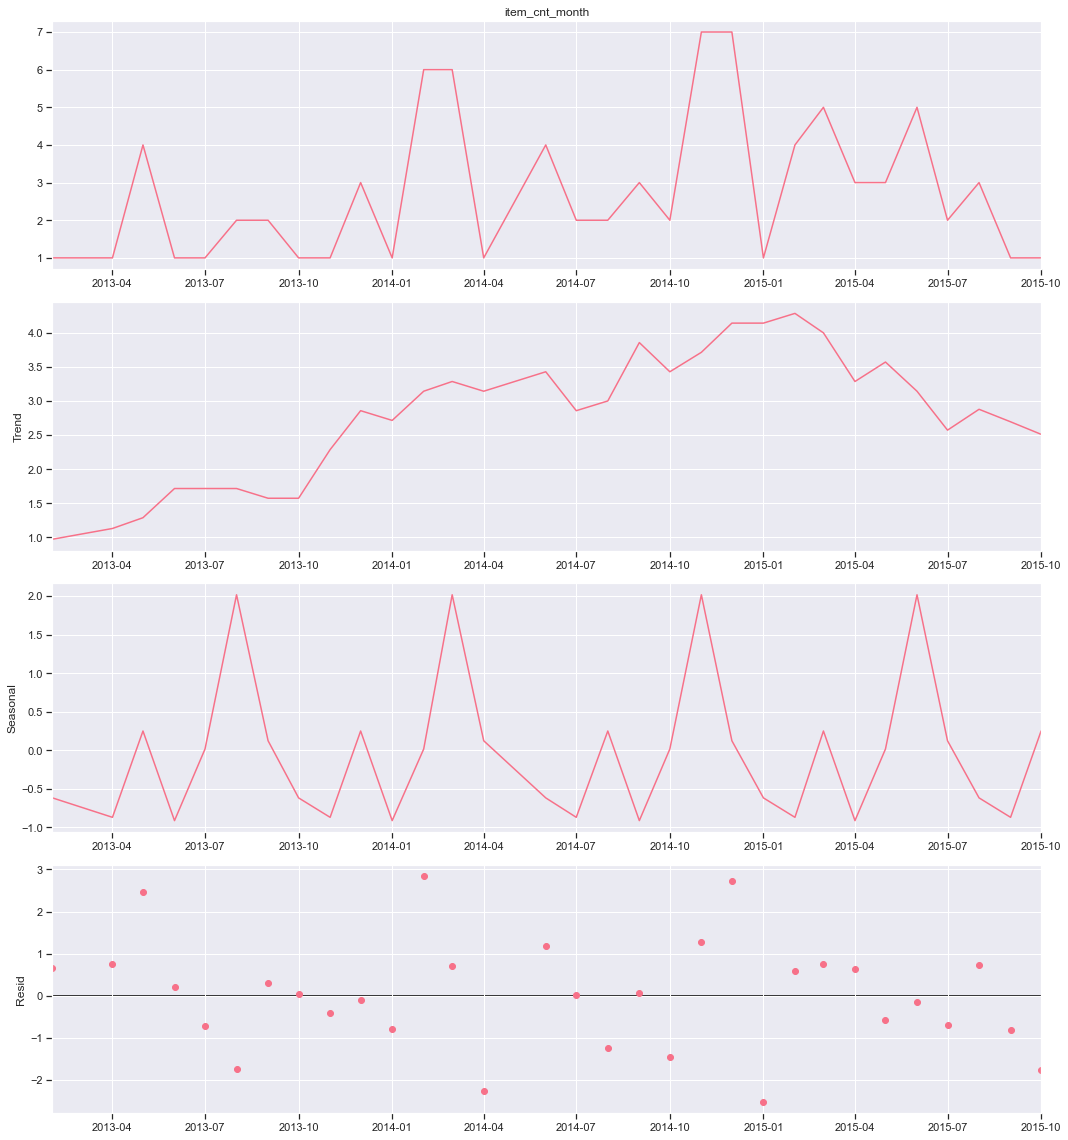

In [18]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 16

decomposition = sm.tsa.seasonal_decompose(ret['item_cnt_month'], model='additive', extrapolate_trend='freq', period=int(31/4))
decomposition.plot()
plt.show()

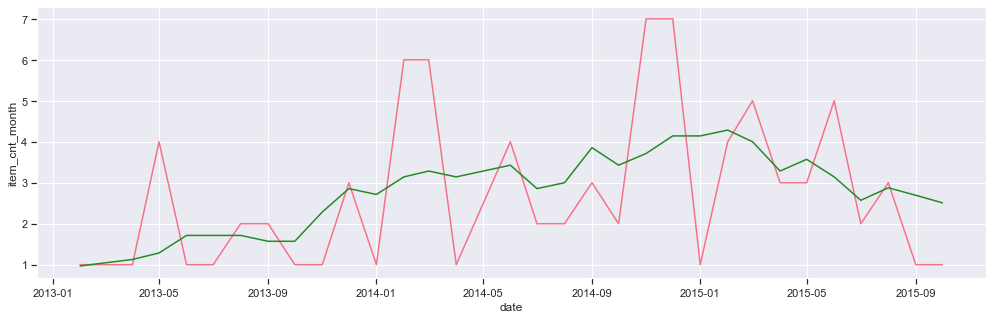

In [19]:
plt.figure(figsize=(17,5))
sns.lineplot(data=ret, x='date', y='item_cnt_month')
plt.plot(decomposition.trend, color='forestgreen')

In [20]:
ret.join(decomposition.trend).head(10)

,date_block_num,shop_id,item_id,month,year,item_category_id,item_cnt_month,item_cnt_month_mean,item_cnt_prev_month,item_name,item_category_name,shop_name,year_mean,trend
date,,,,,,,,,,,,,,
2013-02-01,1,2,5821,2,2013,35,1.0,2.774194,1.0,5821,35,2,1.7,0.969388
2013-04-01,3,2,5821,4,2013,35,1.0,2.774194,1.0,5821,35,2,1.7,1.127551
2013-05-01,4,2,5821,5,2013,35,4.0,2.774194,1.0,5821,35,2,1.7,1.285714
2013-06-01,5,2,5821,6,2013,35,1.0,2.774194,1.0,5821,35,2,1.7,1.714286
2013-07-01,6,2,5821,7,2013,35,1.0,2.774194,1.0,5821,35,2,1.7,1.714286
2013-08-01,7,2,5821,8,2013,35,2.0,2.774194,1.0,5821,35,2,1.7,1.714286
2013-09-01,8,2,5821,9,2013,35,2.0,2.774194,1.0,5821,35,2,1.7,1.571429
2013-10-01,9,2,5821,10,2013,35,1.0,2.774194,1.0,5821,35,2,1.7,1.571429
2013-11-01,10,2,5821,11,2013,35,1.0,2.774194,1.0,5821,35,2,1.7,2.285714


In [21]:
train.drop(columns=['date'], inplace=True)
train['date_full'] = pd.to_datetime(train[['year', 'month']].assign(DAY=1))

In [22]:
train = train.reset_index(drop=True)

In [23]:
train.index = train['date_full']
# train.drop(columns=['date_full'], inplace=True)

In [24]:
train.shape

(1609124, 13)

In [25]:
resample = train.groupby(['shop_id', 'item_id', 'year'])['item_cnt_month'].mean().reset_index().rename(columns={'item_cnt_month':'year_mean'})

train = pd.merge(train.reset_index(drop=True), resample, how='left', on=['shop_id', 'item_id', 'year'])
train.index = train['date_full']
train.drop(columns=['date_full'], inplace=True)

In [26]:
        # shoplist = train['shop_id'].unique()
        # itemlist = train['item_id'].unique()
        # trend_data = pd.DataFrame(columns=['date_full', 'trend', 'shop_id', 'item_id'])

        # for shop in shoplist:
        #     for item in itemlist:
        #         var = train[(train['shop_id']==shop) & (train['item_id']==item)]['item_cnt_month']
        #         try:
        #             periods = int(len(var)/4) if len(var) > 3 else 1

        #             decomposition = sm.tsa.seasonal_decompose(var, 
        #                                                       model='additive', 
        #                                                       extrapolate_trend='freq', 
        #                                                       period=periods)
        #             temp = pd.DataFrame(decomposition.trend).reset_index()
        #             temp['shop_id'] = shop
        #             temp['item_id'] = item
        #             trend_data = trend_data.append(temp,
        #                                       ignore_index=True)
        #         except:
        #             continue
        # trend_data.to_csv('wrangled_data/trends.csv', index=False) 
trend_data = pd.read_csv('wrangled_data/trends.csv')

In [27]:
trend = trend_data
trend['date_full'] = pd.to_datetime(trend['date_full'])
# trend['date'] = trend['date_full'].apply(lambda x: x.strftime('%Y-%m'))
trend = trend.set_index('date_full')

In [28]:
temp = train[(train['shop_id']==2) & (train['item_id']==5821)]

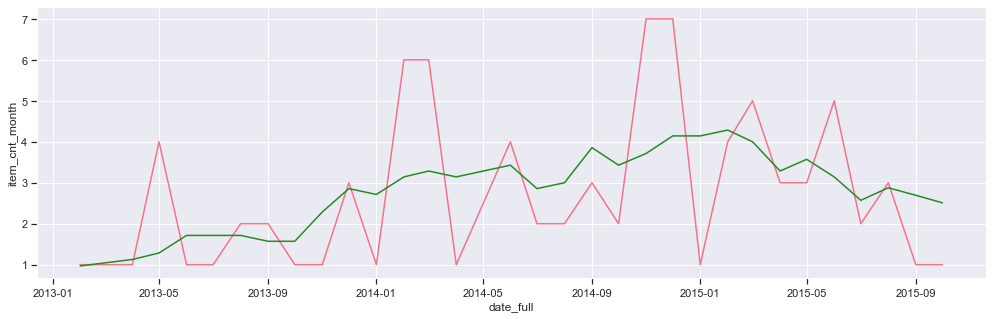

In [29]:
plt.figure(figsize=(17,5))

sns.lineplot(data=temp, x=temp.index, y= 'item_cnt_month')
plt.plot(trend[(trend['shop_id']==2) & (trend['item_id']==5821)]['trend'], color='forestgreen')

In [30]:
null_trend = pd.merge(train.reset_index(), trend.reset_index(), how='left', on=['shop_id', 'item_id', 'date_full'])
null_trend = null_trend[null_trend['trend'].isnull()]

In [31]:
null_trend[(null_trend['shop_id'] == 0) & (null_trend['item_id'] == 43)]

,date_full,date_block_num,shop_id,item_id,month,year,item_category_id,item_cnt_month,item_cnt_month_mean,item_cnt_prev_month,item_name,item_category_name,shop_name,year_mean,trend
3,2013-01-01,0,0,43,1,2013,40,1.0,1.0,0.0,43,40,0,1.0,NaN
